 

# Undersøkelse av ulike metoder for løsning av differensiallikninger

I denne oppgaven skal vi se på fire numeriske metoder for løsning av ordinære differensialligninger og ser på deres egenskaper gjennom undersøkelser av konvergensorden, energibevaring og evne til å gjenskape riktig Poincare-kutt. For å studere de fire numeriske metodene bruker vi den hamiltonske modellen til Henon-Heiles som testmodell, med følgende form:

$$
\begin{align*}
q_1' &= p_1 \\
q_2' &= p_2 \\
p_1' &= -q_1(1+2q_2) \\
p_2' &= -(q_2 + q_1^2 - q_2^2). \\
\end{align*}
$$

De numeriske metodene vi bruker blir implementert og vi vil først teste om de har riktig konvergensorden. Konvergensorden blir testet ved å sammenligne metoden opp mot en referanseløsning, noe som gir en god indikasjon av at metoden er korrekt implementert og fungerer som ventet. Vidre blir metodene testet for en essensiell egenskap ved hamiltonske systemer nemlig energibevaring ved å regne ut systemets hamilton som følge av tid. Tilslutt undersøkes poincare kutt for ulike startverdier og ser på metodenes evne til å replikere riktig poincarekutt.

In [1]:
'''Bibloteker'''

import numpy as np # For alt mulig
import matplotlib.pyplot as plt #plotting 
from numba import jit #optimalisering av kode
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning #for å fjerne advarsler
import warnings
from scipy.integrate import solve_ivp #til referanse løsning
#Få plott i notebook
%matplotlib inline
plt.rcParams['figure.dpi'] = 120 #Gjør plotts fine

import pandas as pd #For tabellfremvisning
import time #Ta tid

# Fjerne unødvendige advarsler
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)



## De numeriske metodene

Under er de fire numeriske metodene implementert. Velger å benytte oss av jit for å oppnå optimalisert kode.

**Metode A: Shampine-Bogackis metode av orden 3**
Shampine-Bogackis løser problemer på form $y' = F(y)$ og er gitt ved

$$
\\ F_1 = F(y_n)
\\
F_2 = F(y_n + \frac12 F_1)
\\
F_3 = F(y_n + \frac34 h F_2)
\\
y_{n+1} = y_n + h(\frac29 F_1 + \frac13 F_2 + \frac49 F_3).
$$

Følger enkelt og greit definisjonen av metoden og implenmenterer metoden ved å bruke pass by reference for å unngå unødvendig minneallokering.


In [2]:
'''Numeriske metoder'''

#Metode A: Shampine-Bogackis metode, orden 3
@jit(nopython = True)
def ShampineBogacki(t0, T, y0, h):
    if ((T-t0)%h) != 0.0: #sjekker om vi kommer til akkurat T ved hjelp av h 
        h_last = (T-t0)%h #Hvis ikke så må vi legge til et lite steg h_last
        n = int((T-t0)/h) + 1  # Antall steg må legge til en for det ekstra steget h_last
    else:
        h_last = h #Hvis h er et heltallig multiplum så trenger vi ikke å gjøre noe
        n = np.int(np.round((T-t0)/h)) #Antall steg
    
    
    y = np.empty((n+1, 4)) #y-array som skal fylles opp, n verdier for 4 størrelser
    y[0,:] = y0 #inertialverdi
    t = np.empty(n+1) #tidsarry
    t[0] = t0
    
    Fvec = np.zeros((4, 3)) #array med alle F-verdiene
    
    for i in range(n): #For hver steglengde utføres Shampine-Bogacki metoden.
        if i == n-1:
            h = h_last
        t[i+1] = t[i] + h 
        
        F(y[i,:], Fvec[:,0]) #F1
        F(y[i,:] + Fvec[:,0] * 0.5 * h, Fvec[:,1]) #F2
        F(y[i,:] + 0.75 * h * Fvec[:,1], Fvec[:,2]) #F3
        
        y[i+1,:] = y[i,:] + h*(2/9 * Fvec[:,0] + 1/3 * Fvec[:,1] + 4/9 * Fvec[:,2])
        
    return y, t

**Metode B: Kuttas metode av orden 4**

Kuttas metode er gitt ved 

$$
F_1 = F(y_n)
\\
F_2 = F(y_n + \frac12 h F_1)
\\
F_3 = F(y_n + \frac12 h F_2)
\\
F_4 = F(y_n + h F_3)
\\
y_{n+1} = y_n + h(\frac16 F_1 + \frac13 F_2 + \frac13 F_3 + \frac16 F_4).
$$

Implementeres ganske likt som Shampine-Bogackis metode.

In [3]:
#Metode B: Kuttas metode, orden 4
@jit(nopython = True)
def Kutta(t0, T, y0, h):
    if ((T-t0)%h) != 0.0: #sjekker om vi kommer til akkurat T ved hjelp av h 
        h_last = (T-t0)%h #Hvis ikke så må vi legge til et lite steg h_last
        n = int((T-t0)/h) + 1  # Antall steg må legge til en for det ekstra steget h_last
    else:
        h_last = h #Hvis h er et heltallig multiplum så trenger vi ikke å gjøre noe
        n = np.int(np.round((T-t0)/h)) #Antall steg

    y = np.empty((n+1, 4)) #y-array som skal fylles opp, n verdier for 4 størrelser
    y[0,:] = y0 #inertialverdi
    
    t = np.empty(n+1) #tidsarry
    t[0] = t0
    
    Fvec = np.zeros((4, 4)) #array med alle F-verdiene
    
    for i in range(n): # For hvert tidssteg utføres Kuttas metode
        if i == n-1:
            h = h_last
        t[i+1] = t[i] + h
        
        F(y[i,:], Fvec[:,0]) #F1
        F(y[i,:] + 1/2 * h * Fvec[:,0], Fvec[:,1]) # F2
        F(y[i,:] + 1/2 * h * Fvec[:,1], Fvec[:,2]) # F3
        F(y[i, :] + h * Fvec[:,2], Fvec[:,3]) # F4
        
        y[i+1, :] = y[i,:] + h*(1/6 * Fvec[:,0] + 1/3 * Fvec[:,1] + 1/3 * Fvec[:,2] + 1/6 * Fvec[:,3])
        
    return y, t

**Metode C: Kahans metode av orden 2**

Kahans metode er definert ved
$$
\frac{y_{i,n+1} - y_{i,n}}{h} = \sum_{j,k = 1}^{m}{a_{ijk}\frac{y_{j,n}y_{k,n+1} + y_{j,n+1}y_{k,n}}{2}} + \sum_{j = 1}^{m}{b_{ij}\frac{y_{j,n} + y_{j,n+1}}{2}} + c_i
$$
Hvor $y_{i,n}$ er den numeriske approksimasjonen til $y_i(t_n)$.

Ønsker nå å omskrive systemet til et generelt kvadratisk system på matriseform ala $A\vec{y_{n+1}} = \vec{d}$ som da kan enkelt løses for $\vec{y_{n+1}}$ ved hjelp av biblioteksrutiner. Vi løser kahans metode definert i prosjekt beskrivelsen for $y_{i,n+1}$.

$$
\frac{y_{i, n+1}}{h} - \sum_{j,k = 1}^{m}{a_{ijk}\frac{y_{j,n}y_{k,n} + y_{j,n+1}y_{k,n}}{2}} - \sum_{j = 1}^{m}{b_{ij}\frac{y_{j,n+1}}{2}} = \sum_{j = 1}^{m}{b_{ij}\frac{y_{j,n}}{2}} + c_i
$$

Vi må altså finne koeffsientene $a_{ijk}, b_{ij}, c_i$ som er gitt av den generelle formen for et kvadratisk system.

$$
y_i' = \sum_{j,k = 1}^{m}{a_{ijk}y_jy_k} + \sum_{j = 1}^{m}{b_{ij}y_j} + c_i , i = 1,..., m.
$$

Vi omskriver Henon-Heiles til y-form for enklere sammenlingning,

$$
\begin{align*}
y_1' &= y_3 \\
y_2' &= y_4 \\
y_3' &= -y_1(1+2y_2) \\
y_4' &= -(y_2 + y_1^2 - y_2^2). \\
\end{align*}
$$

Kan da lese av koeffsientene:

$$
a_{321} = -2 , a_{411} = -1 , a_{422} = 1,
$$

$$
b_{13} = 1, b_{24} = 1, b_{31} = -1, b_{42} = -1.
$$

Alle andre koeffsienter $a_{ijk}, b_{ij}, c_i$ er lik null.

Dermed kan vi nå sette opp matrisesystemet vårt for kahans metode,

$$
\begin{pmatrix}
1/h & 0 & -1/2 & 0 \\
0 & 1/h & 0 & -1/2 \\
\frac12 + y_{2,n} & y_{1,n} & 1/h & 0 \\
y_{1,n} & \frac12 - y_{2,n} & 0 & 1/h \\
\end{pmatrix}
\begin{pmatrix}
y_{1,n+1}\\
y_{2,n+1} \\
y_{3,n+1} \\
y_{4, n+1} \\
\end{pmatrix}
=
\begin{pmatrix}
y_{1,n}/h + y_{3,n}/2\\
y_{2,n}/h + y_{4, n}/2\\
y_{3,n}/h - y_{1,n}/2\\
y_{4,n}/h - y_{2,n}/2\\
\end{pmatrix}
$$

som da må løses for hver iterasjon.


In [4]:
#Metode C: Kahans metode, orden 2

@jit(nopython = True)
def makeAb(yn, h, A, b): #Lager først en liten hjelpe funksjon for å oppdatere matrisa A og vektoren b
    A[2, 0] = 1/2 + yn[1] #De y-avhengige verdiene i A
    A[2, 1] = yn[0]
    A[3,0] = yn[0]
    A[3,1] = 1/2 - yn[1]
    
    for j in range(4): #Setter inn konstante størrelser for matrise A
        A[j,j] = 1/h #diagonalen til A
    A[0,2] = -1/2
    A[1,3] = -1/2
    
    a = [1, 1, -1, -1]
    for i in range(4):
        b[i] = yn[i]/h + a[i] * yn[i-2]/2 #Oppdaterer b med y avhengige verdier

        
    
@jit(nopython = True)
def Kahan(t0, T, y0, h):
    if ((T-t0)%h) != 0.0: #sjekker om vi kommer til akkurat T ved hjelp av h 
        h_last = (T-t0)%h #Hvis ikke så må vi legge til et lite steg h_last
        n = int((T-t0)/h) + 1  # Antall steg må legge til en for det ekstra steget h_last
    else:
        h_last = h #Hvis h er et heltallig multiplum så trenger vi ikke å gjøre noe
        n = np.int(np.round((T-t0)/h)) #Antall steg
    
    y = np.empty((n+1, 4)) #y-array som skal fylles opp, n verdier for 4 størrelser
    y[0,:] = y0 #inertialverdi
    
    t = np.empty(n+1) #tidsarry
    t[0] = t0
    
    A = np.zeros((4,4)) #Størrelser for matrise ligning
    
    b = np.zeros(4) #b -vektoren
    
    for i in range(n): #Kjører gjennom alle tidsstegene og løser systemet.
        if i == n-1:
            h = h_last
            
        t[i+1] = t[i] + h
        
        makeAb(y[i,:], h, A , b)
        y[i+1,:] = np.linalg.solve(A,b) #løser systemet ved hjelp av numpys solve funksjonn

    return y, t

**Metode D: Störmer-Verlets metode av orden 2**
Störmer-Verlets metode er gitt ved

$$
p_{n+\frac12} = p_n + \frac12 h f(q_n)
\\
q_{n+1} = q_n + hp_{n+\frac12}
\\
p_{n+1} = p_{n+\frac12} + \frac12 h f(q_{n+1})
$$
Metoden gjelder for et andre ordens system $q'' = f(q)$ omskrevet til et førsteordens system. Siden Henon-Heiles er et slikt system skriver vi først om Henon-Heiles til et andreordens system slik at vi ser hva $f(q)$ er. 

$$
p_1 = q_1' \implies q_1'' = -q_1-2q_2q_1 \\
p_2 = q_2' \implies q_2'' = -q_2 - q_1^2 + q_2^2.
$$
Kan da implementere metoden ganske likt som de to første.

In [5]:
#Metode D: Stormer-Verlet, orden 2
@jit(nopython = True)
def StormerVerlet(t0, T, y0, h):
    if ((T-t0)%h) != 0.0: #sjekker om vi kommer til akkurat T ved hjelp av h 
        h_last = (T-t0)%h #Hvis ikke så må vi legge til et lite steg h_last
        n = int((T-t0)/h) + 1  # Antall steg må legge til en for det ekstra steget h_last
    else:
        h_last = h #Hvis h er et heltallig multiplum så trenger vi ikke å gjøre noe
        n = np.int(np.round((T-t0)/h)) #Antall steg
        
    y = np.empty((n+1, 4)) #y-array som skal fylles opp, n verdier for 4 størrelser
    y[0,:] = y0 #inertialverdi
    
    t = np.empty(n+1) #tidsarry
    t[0] = t0
    
    fn = np.zeros(2) #Inholder verdi til f(q_n)
    f(y[0,:], fn) #Legger inn riktige verdier av f(q_n)
    
    
    for i in range(n):
        if i == n-1:
            h = h_last
        t[i+1] = t[i] + h
        
        p12 = y[i, 2:] + 1/2 * h * fn #Regner ut p_n+1/2
        y[i+1, :2] = y[i, :2] + h * p12 #Regner ut q_n+1
        f(y[i+1,:], fn) #Oppdaterer til f(q_n+1)
        y[i+1, 2:] = p12 + 1/2 * h * fn #Regner ut p_n+1

    return y, t

Tilslutt legger vi inn tre funksjoner F(y, Fvec), f(y, P) og Fref(t,y) som alle returnerer høyresiden av systemet på forskjellige måter.

In [6]:

#Høyresidene av systemene:

@jit(nopython = True)
def F(y, Fvec): #hele høyreside av system
    Fvec[0] = y[2]
    Fvec[1] = y[3]
    Fvec[2] = -y[0]*(1 + 2*y[1])
    Fvec[3] = -(y[1] + y[0]**2 - y[1]**2)
    

@jit(nopython = True)
def f(y, P): #Høyreside til p-system
    P[0] = -y[0] - 2 * y[0] * y[1]
    P[1] = -y[1] - y[0]**2 + y[1]**2

@jit(nopython = True)
def Fref(t, y): #Funksjo som returnerer høyresiden, trengs til solve_ivp
    Fvec = np.copy(y)
    Fvec[0] = y[2]
    Fvec[1] = y[3]
    Fvec[2] = -y[0]*(1 + 2*y[1])
    Fvec[3] = -(y[1] + y[0]**2 - y[1]**2)
    
    return Fvec

## Oppgave 1 

Skal nå sjekke konvergensordenen til de numeriske metodene, gjør dette ved å estimere global feil ved å regne ut forskjell mellom løsning gitt av våre metoder og scipy.integrate.solve_ivp() som benytter seg av RK45 med strenge toleransekrave rtol og atol. 

In [15]:
'''Oppgave 1: Verifikasjon av konvergensorden for globalfeil'''

def convergence(solve, nexps, t0, T, y0, order, name, K = 1):
        ta = time.time()
        h = np.logspace(0, -5, num = nexps) #logaritmisk fordelt steglengder
        yref = (solve_ivp(Fref, (t0, T), y0, atol = 1e-12, rtol = 1e-12).y).T #Referanseløsning med bruk av scipy.solve_ivp, transponerer for få samme format som yest
        errors = np.zeros(nexps) #Array for feilestimater
        ordEst = np.zeros(nexps - 1) #Array for orden-estimater
        
        for i in range(nexps): #Iterer gjennom alle steglengder
            
            yest, test = solve(t0, T, y0, h[i]) #Regner ut y med valgt løsningsmetode
            errors[i] = np.linalg.norm(yest[-1,:] - yref[-1,:]) #Estimerer feilen basert på normen
            
            if i > 0:
                ordEst[i-1] = np.log(errors[i] / errors[i-1]) / np.log(h[i] / h[i-1]) #Estimerer orden
                
        
        #print(f'Estimert orden for hvert etterfølgende skrittlengde par: \n {ordEst}') 
        df = pd.DataFrame({"Estimert Orden:":ordEst})
        df.index = np.abs(np.diff(h))
        df.index.name = r"|Δh|"
        
        print(df)
        plt.figure() #Plotter global feil og forventet stigningstall
        plt.loglog(h, errors, label = 'Global feil')
        plt.loglog(h, K * h**(order), '--', label = f'Forventet stigningstall = {order}')
        plt.grid()
        plt.legend()
        plt.ylabel('Feil')
        plt.xlabel('Steglengde h')
        plt.title(f'Konvergenstest av {name}')
        plt.show()
        print(f'Tid brukt: {time.time()- ta} s')
y_0 = np.array((0, 0, 0.2, 0.3))


          Estimert Orden:
|Δh|                     
0.454441         2.672654
0.247924         2.932088
0.135257         3.007619
0.073791         3.014250
0.040257         3.011715
0.021963         3.007403
0.011982         3.003995
0.006537         3.002443
0.003566         3.001747
0.001946         3.003235
0.001061         3.016562
0.000579         3.103561
0.000316         3.832947
0.000172         1.141273
0.000094        -0.650978
0.000051        -0.087318
0.000028        -0.009678
0.000015        -0.004387
0.000008        -0.003049


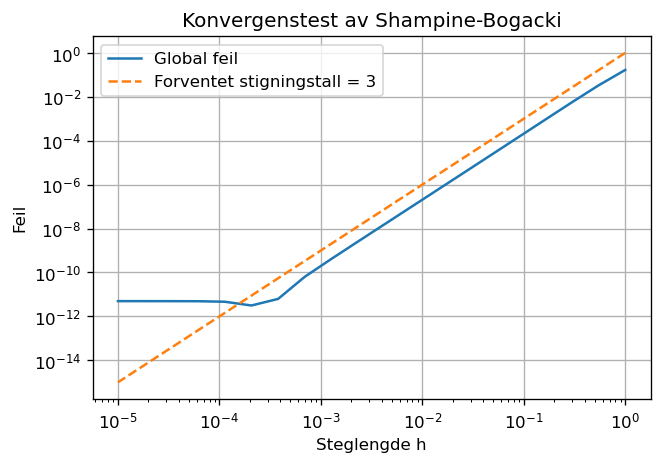

Tid brukt: 1.4599037170410156 s


In [16]:
convergence(ShampineBogacki, 20, 0, 10, y_0, 3, "Shampine-Bogacki") #Tester konvergensorden til Shampine-Bagackis metode

          Estimert Orden:
|Δh|                     
0.454441         3.863751
0.247924         3.924558
0.135257         3.942855
0.073791         3.964836
0.040257         3.981020
0.021963         3.989689
0.011982         3.993400
0.006537         3.985512
0.003566         3.799371
0.001946         1.773567
0.001061         0.125152
0.000579         0.008710
0.000316        -0.000274
0.000172        -0.002203
0.000094         0.004742
0.000051        -0.003167
0.000028         0.003312
0.000015        -0.002227
0.000008        -0.002522


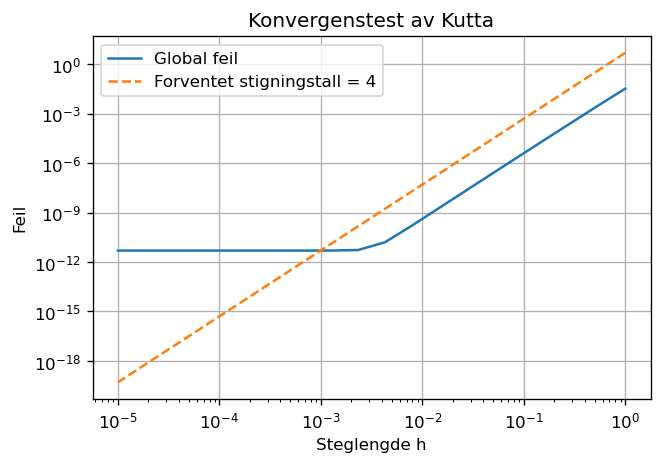

Tid brukt: 2.2696149349212646 s


In [10]:
convergence(Kutta, 20, 0, 10, y_0, 4, "Kutta", 5)#Tester konvergensorden til Kuttas metode

          Estimert Orden:
|Δh|                     
0.454441         1.754083
0.247924         1.927399
0.135257         1.976890
0.073791         1.991486
0.040257         1.997526
0.021963         1.999366
0.011982         1.999622
0.006537         1.999911
0.003566         1.999957
0.001946         1.999955
0.001061         1.999986
0.000579         1.999981
0.000316         1.999976
0.000172         1.999924
0.000094         1.999622
0.000051         2.000176
0.000028         1.991002
0.000015         2.000564
0.000008         1.188042


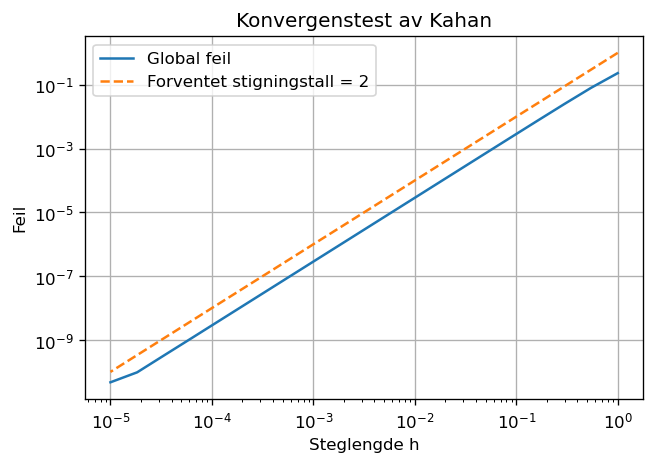

Tid brukt: 4.57793402671814 s


In [11]:
convergence(Kahan, 20, 0, 10, y_0, 2, "Kahan")#Tester konvergensorden til Kahans metode

          Estimert Orden:
|Δh|                     
0.454441         2.388914
0.247924         2.067279
0.135257         2.026937
0.073791         2.010321
0.040257         2.002637
0.021963         2.000628
0.011982         2.000414
0.006537         2.000087
0.003566         2.000046
0.001946         2.000057
0.001061         2.000016
0.000579         2.000020
0.000316         2.000024
0.000172         2.000062
0.000094         2.000176
0.000051         2.000565
0.000028         2.001431
0.000015         1.998983
0.000008         1.933041


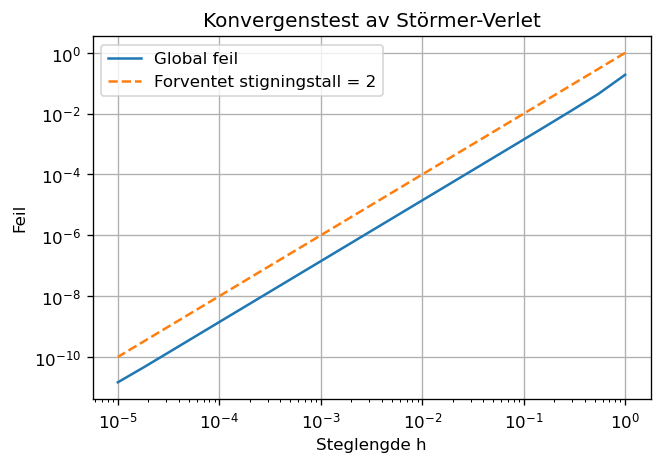

Tid brukt: 1.8564727306365967 s


In [12]:
convergence(StormerVerlet, 20, 0, 10, y_0, 2, "Störmer-Verlet")#Tester konvergensorden til Störmer-Verlets metode

**Diskusjon** 

Vi observerer at alle metodene har forventet stigninstall og estimert orden for visse områder av steglengden h. Shampine-Bogacki, Kutta og Kahan brekker alle av når steglengden blir liten nok($feil \approx 10^{-10}$), dette er som forventet fra teorien i prosjektbeskrivelsen, den estimerte feilen blir kontaminert av at referanseløsningen i seg selv ikke er den analytiske løsningen, i tillegg blir vil også avrundingsfeiil påvirke estimatet. Denne effekten ser vi ikke intreffer hos Störmer-Verlets metode, men vi observerer at den estimerte feilen ikke blir like lav som ved Shampine-Bogackis og Kuttas metode, noe som kan tyde på at hadde simulasjonen kjørt for enda mindre steglengder ville også Störmer-Verlets metode brekket av. 

Som forventet observerer vi at de høyere ordens metodene Shampine-Bogacki og Kahan generelt har et lavere feilestimat enn de lavere ordens metodene Kahan og Störmer-Verlet. Dette gir mening da feilen skal være proposjonal med $h^{orden}$, altså høyere ordens metoder skal ha lavere feil. 

## Oppgave 2

Skal nå studere energibevarelse i systemet. I Henon-Heils modellen er hamilton funksjonen gitt ved

$$
H(q_1,q_2,p_1,p_2) = \frac12 (p_1^2 + p_2^2) + U(q), 
$$

med 
$$
U(q_1, q_2) = \frac12 (q_1^2 + q_2^2) + q_1^2q_2 - \frac13 q_2^3.
$$
Hamiltonske systemer har den egenskapen at systemets energi er bevart , altså skal $H(q(t), p(t)) = H(q_0, p_0)$ for alle $ t\geq 0.$

Vi vil nå teste ut de ulike metodens grad av energibevarelse. Basert på oppgave 1 virker steglengde $h = 10^{-2}$ som et fornuftig valg for å få lav feil, videre bruker vi  sluttid $T = 1 \cdot 10^{5} s.$ Implementerer aller først en hamilton funksjon som retunerer systemets energi og en check-energy funksjon som regner ut løsning med valgt løsningsmetode og plotter hamilton funksjonen som funksjon av tid$(t\in[t_0, T])$ sammen med hamilton funksjonens startverdi, $H_0$. Itillegg plottes hamilton funksjonen over et korterer tidsintervall$(T = 50s)$ for å kunne lettere se funksjonens struktur. Funksjonen skriver også ut litt enkel statistikk som differansen mellom start og slutt i hamilitonfunksjonen og gjennomsnittlig differanse fra startpunktet for alle tidsverdier.

In [60]:
'''Oppgave 2: Energibevarelse'''
plt.rcParams['figure.dpi'] = 100
@jit(nopython = True)
def Hamilton(y): #Funksjon som returnerer hamilton-funksjonens verdi gitt systemet y
    if y.ndim>1:
        return 1/2*(y[:,2]**2 + y[:,3]**2) + 1/2 * (y[:,0]**2 + y[:,1]**2) + y[:,0]**2 * y[:,1] - 1/3 * y[:,1]**3
    else:
        return 1/2*(y[2]**2 + y[3]**2) + 1/2 * (y[0]**2 + y[1]**2) + y[0]**2 * y[1] - 1/3 * y[1]**3

    
def checkEnergy(solve, t0, T, y0, h, name): #Studerer Hamilton-funksjonens tidsutvikling, og dermed energibevarelse.
    y, t = solve(t0, T, y0, h) #Løser først systemet med valgt metode
    H = Hamilton(y) #Finner sp hamilton funksjonen
    
    diff = np.abs(H[-1] - H[0]) #Absolutt differanse
    diffAv = np.average(H - H[0]) #Gjennomsnittlig differanse
    print(f"Hamilton start: {H[0]}, Hamilton slutt(t = T): {H[-1]}, differanse: {diff}\nGjennomsnittlig differanse: {diffAv}")
    
    H0 = np.ones(t.size) * H[0] #Startverdi-array for plotting
    
    fig, axs = plt.subplots(2, 1, figsize = (6,6)) #Plotter hamiltonfunksjonen for hele tidsintervallet, og for et mindre tidsintervall   
    axs[0].plot(t, H, label = r'$H(t)$')
    axs[0].plot(t,H0 , label = r'$H_0$')
    axs[1].plot(t[: int(50 / h)], H[:int(50/h)], label = r'$H(t)$')
    axs[1].plot(t[: int(50/ h)], H0[:int(50/h)], label = r'$H_0$')
    fig.suptitle(f'Test av energibevarelse i {name}')
    axs[0].grid()
    axs[1].grid()
    axs[0].set_xlabel('Tid t[s]')
    axs[1].set_xlabel('Tid t[s]')
    axs[0].set_ylabel('Energi H')
    axs[1].set_ylabel('Energi H')
    axs[0].legend(loc = 'lower left')
    axs[1].legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()


Hamilton start: 0.065, Hamilton slutt(t = T): 0.06438862670104847, differanse: 0.0006113732989515286
Gjennomsnittlig differanse: -0.0003062596630274718


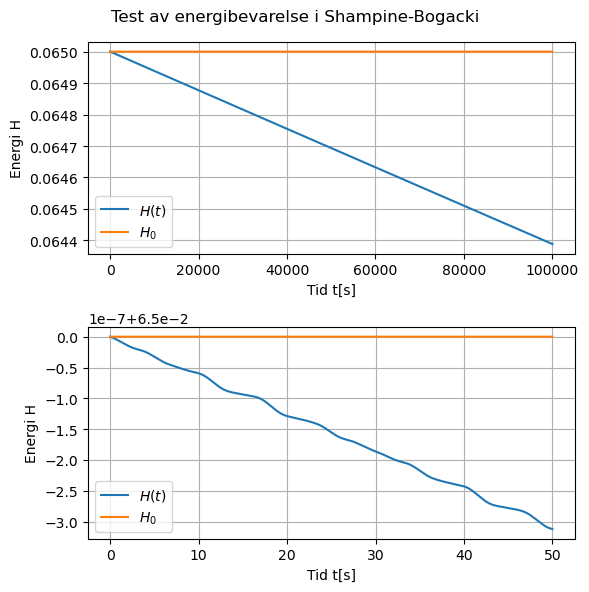

In [61]:
checkEnergy(ShampineBogacki, 0, 1e5, y_0, 1e-2, "Shampine-Bogacki") #Ser på tidsbevarelse i Shampine-Bogacki

Hamilton start: 0.065, Hamilton slutt(t = T): 0.06499998557139272, differanse: 1.4428607281180561e-08
Gjennomsnittlig differanse: -7.213420225497298e-09


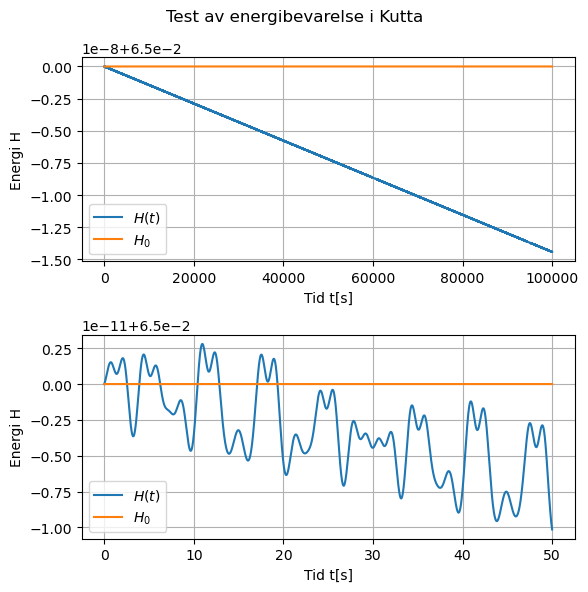

In [62]:
checkEnergy(Kutta, 0, 1e5, y_0, 1e-2, "Kutta")#Ser på energibevarelse i kuttas metode

Hamilton start: 0.065, Hamilton slutt(t = T): 0.06500012292568567, differanse: 1.2292568567218165e-07
Gjennomsnittlig differanse: -6.648997875846343e-08


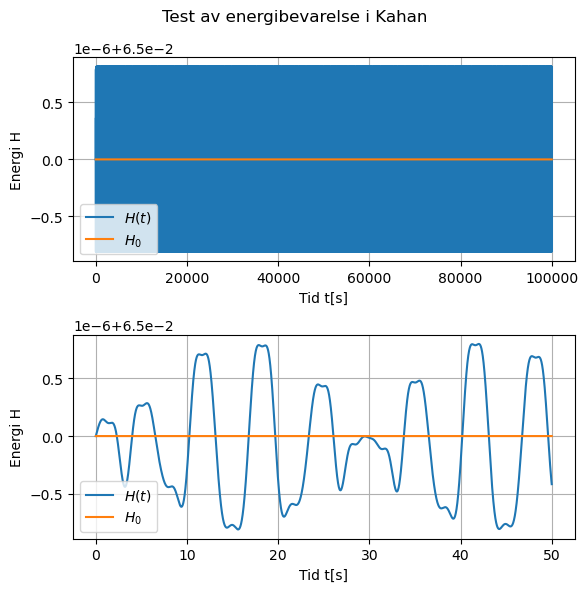

In [63]:
checkEnergy(Kahan, 0, 1e5, y_0, 1e-2, "Kahan") # Ser på energibevarelse i Kahans metode

Hamilton start: 0.065, Hamilton slutt(t = T): 0.06500114985733502, differanse: 1.1498573350143815e-06
Gjennomsnittlig differanse: 8.20830313873577e-07


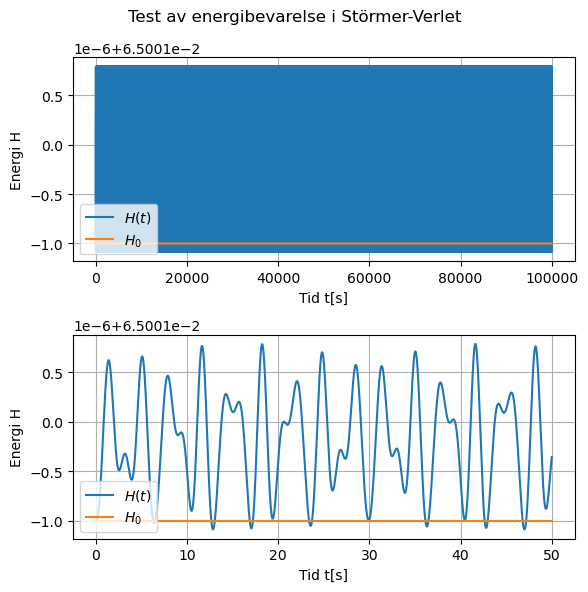

In [64]:
checkEnergy(StormerVerlet, 0, 1e5, y_0, 1e-2, "Störmer-Verlet") #Ser på energibevarelse i Störmer-Verlet

**Diskusjon**

Vi obserever at alle meotdene er oscillerende i estimatet av systemets hamilton, altså er de ikke energi-bevarende. Mest merkeverdig er at Shampine-Bogacki og Kuttas metode drifter bort fra $H_0$, og spesielt for Shampine-Bogackis metode endrer systemets hamilton svært mye bare på $T = 3\cdot 10^{5} $ s. Kuttas metode drifter også men i mindre grad enn Shampine-Bogacki, faktisk har Kuttas metode den laveste slutt differansen. Både Störmer-Verlet og Kahans metode drifter ikke vekk fra $H_0$ men forblir i det samme området, dette gjør at den gjennomsnittlige differansen vil være ganske lik slutt differansen. Kahans metode oscillerer omtrentlig akkurat rundt $H_0$ mens Störmer-Verlet oscillerer rundt en verdi høyere enn $H_0$. Dette tyder på at Kahans metode og Störmer-Verlets metode er bevarende for en modifisert/pertubert Hamilton, som vist med Kahans metode i $[1]$. 

Basert på dette kan man trekke slutninger om at hvis man skal integrere over små tidsrom så vil Kuttas metode gi det minste feilestimatet og gi minst differanse i avik fra systemets hamilton. Hvis man derimot ønsker å se på store tidsrom, feks utviklingen til en galakse over millioner av år, vil Kuttas metode og Shampine-Bogacki drifte betydlig fra systemets virkelige hamilton, og dermed kontaminere løsningen. I slike tilfeller vil det være svært mer hensiktsmessig å velge enten Störmer-Verlets metode eller Kahans metode som vil oscillere rundt det samme punktet uavhengig bredden i tidsrommet. Kahans metode vil være det mest naturlige valget da denne oscillerer rundt $H_0$ og vil da gi det laveste gjennomsnittlige aviket fra $H_0$.

## Oppgave 3

I denne siste oppgaven skal vi studere metodenes Poincarè-kutt. Ser på tidsintervallet $[0, 10^6]$ og bruker $H_0 = \frac{1}{12}$. For å få denne $H_0$ verdien "låser" vi noen av startverdiene til faste verdier, vi lar

$$
q_{0,1} = 0\\
q_{0,2} = 0.45\\
p_{0,2} = 0.
$$

Dermed kan vi beregne $H_0$, 
$$
U_0(q_{0,1}, q_{0,2}) = \frac12 0.45^2 -\frac13 0.45^3 = 0.070875 \implies H_0 = \frac12 p_{0,1}^2 + 0.070875\\
\implies p_{0,1} = +\sqrt{2(H_0 - 0.070875)}.
$$

For å bergene Poincarè-kuttet ser vi på underrommet hvor $q_1 = 0$ og finner ut hvor i $(q_2, p_2)$ rommet løsningen vår skjærer i underromet $(0, q_2, p_1, p_2)$, dvs der $q_1 = 0$, i tillegg halverer vi planet ved å kun se på løsningene i retningen hvor $p_1 > 0$. For å finne de relevante løsningsverdiene itererer vi gjennom løsningen og ser når $q_1$ skifter fortegn, deretter utfører vi lineær interpolasjon over det relevante tidsrommet for å finne nullpunktet mer nøyaktig.

Velger her å lage først en Poincare() funksjon som returnerer de $q_2 , p_2$ verdiene hvor kuttet skjer. Lager så en annen funskjon plotPoincare() for plotting av kuttene som henter ut verdiene fra Poincare-funksjonen for et utvalg av sluttider $T$ og steglengder $h$ og plotter disse for alle løsningsmetodene. Har valgt å senke sluttiden $T$ når steglengden minker slik at simulasjonen ikke skal ta for lang tid. 

In [15]:
'''Oppgave 3 Poincare-Kutt'''
    
@jit(nopython = True)
def Poincare(solve, t0, T, h, H0): #Funksjon som beregner Poincare kutt i q2,p2 -planet
    p01 = np.sqrt(2*(H0 - 0.070875)) #Startverdi til p01 gitt H0
    y0 = np.array((0,0.45, p01, 0 )) #Intertialverdi
    y, t = solve(t0, T, y0, h) #Løser systemmet med valgt metode
    q2p2 = [[np.float64(x) for x in range(0)],[np.float64(x) for x in range(0)]]#Oppretter array for lagring av (q2,p2), spesifiserer type for å bruke jit
    
    for i in range(y[:,0].size - 1): #Itererer gjennom alle tidssteg og sjekker betingelsene våre
        if y[i,2] > 0 and (np.sign(y[i,0]) != np.sign(y[i+1,0])) and (np.sign(y[i,0]) != 0) and (np.sign(y[i+1,0]) != 0):
            
            tInterp = np.linspace(t[i], t[i+1], 100) #Gjør en svært enkel lineær interpolasjon for å få mer nøyaktige verdier.
            q2 = (y[i+1,1]- y[i,1])/(t[i+1] - t[i]) * (tInterp - t[i]) + y[i, 1]
            p2 = (y[i+1,3]- y[i,3])/(t[i+1] - t[i]) * (tInterp - t[i]) + y[i, 3]
            q1 = (y[i+1,0]- y[i,0])/(t[i+1] - t[i]) * (tInterp - t[i]) + y[i, 0]
            index = np.where(np.abs(q1) == np.min(np.abs(q1)))
            
            q2p2[0].append(q2[index[0][0]])
            q2p2[1].append(p2[index[0][0]])
            
            
    return np.array(q2p2) #Returnerer (n+1)x2 array med verdiene hvor kuttet skjer

def plotPoincare(t0, H0):  #Funksjon for plotting av Poincare-kutt
    timehdict = {1e6: 1e-1, 1e5: 1e-2, 1e4: 1e-3, 1e3: 1e-4} #Dictionary for sluttid-steglengde par
    solvedict = {ShampineBogacki:["Shampine-Bogacki",0,0], Kutta: ["Kutta",0,1], Kahan: ["Kahan",1,0], StormerVerlet: ["Störmer-Verlet",1,1]}
    #Dictionary for iterasjon gjennom metodene med navn og "koordinater" til subplotsene. 
    
    ta = time.time() # Tar tiden 
    fig, axs = plt.subplots(2,2, figsize = (9,9))#Plotter scatterplott av p2 som følge av p2 for alle metodene 

    for solve in solvedict: #Itererer gjennom metodene
        for T in timehdict: #Itererer gjennom sluttid-steglengde par
            q2p2 = Poincare(solve, t0,T , timehdict[T], H0) #Bruker Poincare 
            axs[solvedict[solve][1], solvedict[solve][2]].scatter(q2p2[0], q2p2[1],marker = '.', label = f'T = {"{:.0e}".format(T)}, h = {"{0:.0e}".format(timehdict[T])}')
        axs[solvedict[solve][1], solvedict[solve][2]].legend(title = f'{solvedict[solve][0]}', loc = 'center')
        
    fig.suptitle(f'Poincare-kutt for $H_0$ = {round(H0, 3)}')
    axs[1,1].set_xlabel(r"$q_2$")
    axs[1,0].set_xlabel(r"$q_2$")
    axs[1,0].set_ylabel(r"$p_2$")
    axs[0,0].set_ylabel(r"$p_2$")
    plt.tight_layout()
    plt.show()
    print(f"Tid brukt: {np.round(time.time() - ta, 2)} s")

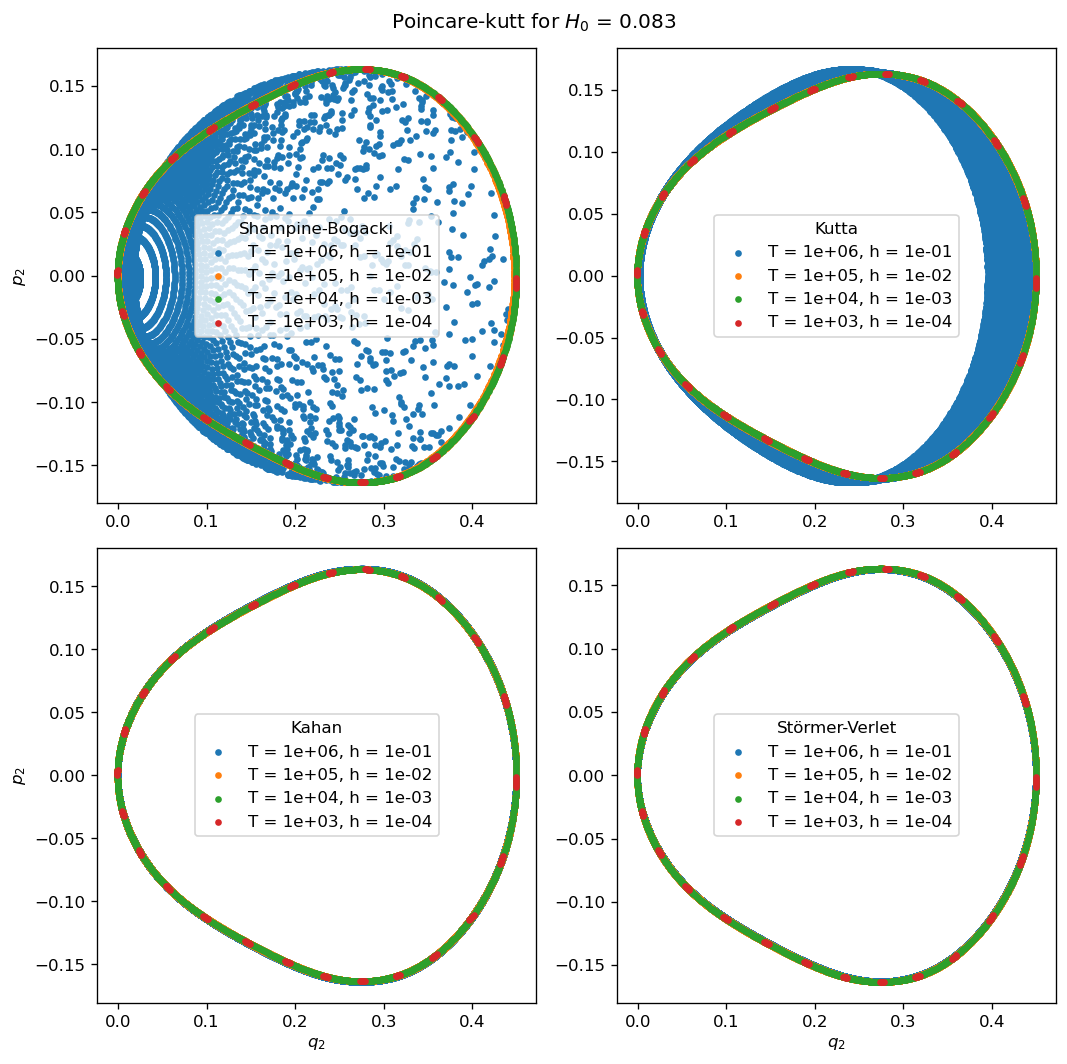

Tid brukt: 97.15 s


In [16]:
plotPoincare(0, 1/12)

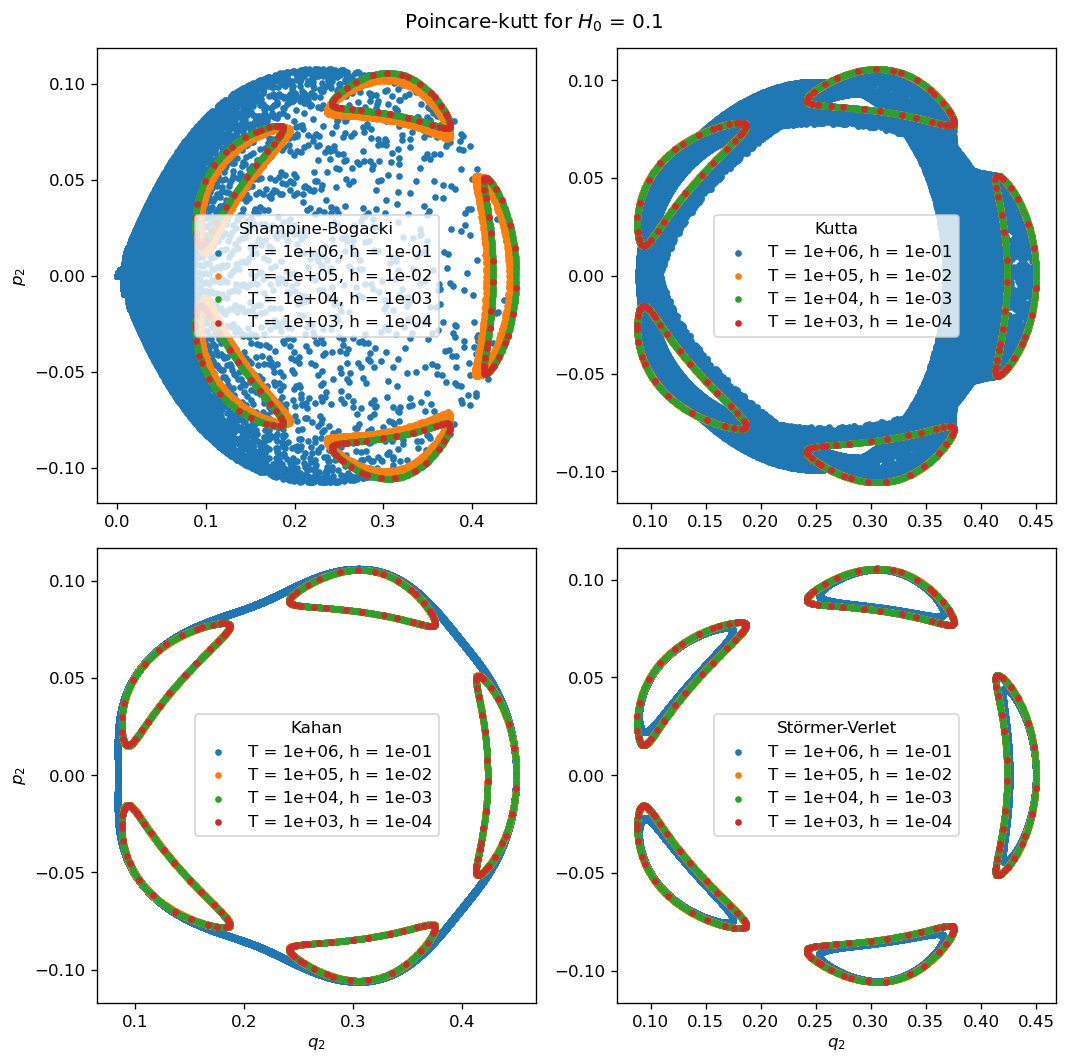

Tid brukt: 94.37 s


In [17]:
plotPoincare(0, 1/10)

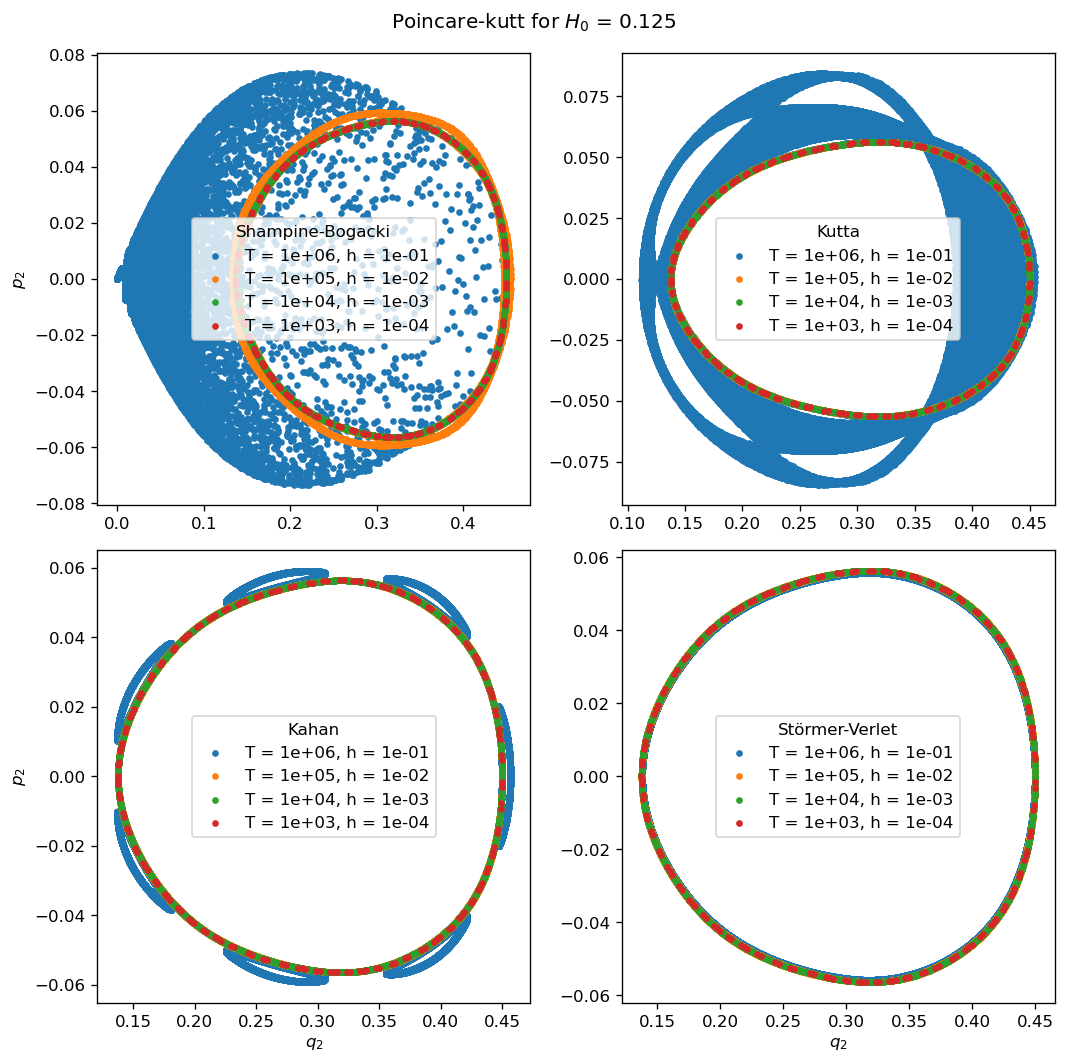

Tid brukt: 79.65 s


In [18]:
plotPoincare(0 , 1/8)

**Diskusjon**

Plottene over er for henholdsvis $H_0 = \frac{1}{12}, \frac{1}{10}, \frac{1}{8}$ og illustrerer signifikante forskjeller i metodenes evne til å gjengi riktig poincare kutt når steglengden blir stor. 

* $H_0 = \frac{1}{12}$: Vi observerer at for $T = 10^{6}$ og $h = 10^{-1}$ feiler Shampine-Bogackis metode totalt med å gi ut riktig poincare-kutt og heller indikerer at banen er kaotisk. Kuttas metode gjengir den riktige formen og får en lukket kurve for $T = 10^{6}$ og $h = 10^{-1}$  men har generelt en ujevn tykkelse i linjen som ikke er ventet og som ville indikert at banen vil utvikle seg til å bli mer kaotisk over tid. For de mindre steglengdene greier dog både Shampine-Bogacki og Kuttas metode å gjengi banen korrekt. Kahans metode og Störmer-Verlets metode gjengir den riktige formen med en riktige tykkelse i linjen for alle kombinasjonene av steglengde og slutttid. Forskjellene i kuttene har trolig samenheng med resultatene i oppgave 2, siden kuttas metode drifter vekk fra den virkelige hamiltonen vil vi kunne krysse flere punkter i underromet hvilket gir en økt tykkelse i kuttet. Vi ser dermed klart at dersom man skal bruke Kuttas metode eller Shampine-Bogackis metode er man avhengig av å ha en lav nok steglengde for å ikke få kaotiske løsninger. Med de andre metodene kan man nøye seg med lavere steglengder og likevel få korrekte løsninger.

* $H_0 = \frac{1}{10}$: Her kommer flere forskjeller frem, nå er det kun Störmer-Verlets metode som greier å gjengi banen korrekt for alle steglengdene, mens de andre metodene er avhengig av mindre steglengder for å få riktig poincare-kutt. Grunnen til at Störmer-Verlets metode gjør det bedre enn Kahan her er ikke helt sikkert, men Störmer-Verlets metode er en symplektisk metode$[2]$, noe Kahans metode ikke er. Dette kan være signifikant da et poincare-kutt / mapping på et hamiltonsk system er symplektisk $[3]$, altså har mappingen areal-bevarende egenskaper. Dermed gir det mening at en symplektisk metode gjengir poincare-kuttet korrekt selv for store steglengder. 

* $H_0 = \frac{1}{8}$: I dette siste plottet bekreftes vår mistanke om at det er Störmer-Verlets metode som gjengir banen mest korrekt. Her er det igjen kun Störmer-Verlet som gir riktig bane for alle steglengdene mens de andre metodene feiler i å gjøre det samme.

**Konklusjon**

Grafene til Shampine-Bogacki(metode A) og Kutta(metode B) sine metoder for energibevarelse viser at energien drifter vekk fra den egentlige verdien. For Kahan(metode C) og Störmer-Verlet(metode D) ser man at energien holder seg rundt den egentlige verdien, uavhengig av tiden. Dette tyder på at metode C og D er bedre enn metode A og B, noe som også bygges under av det første plottet i oppgave 3 $(H_0 = 1/12)$. Der ser man at metode C og D har lite avvik, uavhengig av steglengde, mens metode A og B avviker for større steglengder. Det andre$(H_0 = 1/10)$ og tredje$(H_0 = 1/8)$ plottet i oppgave 3, viser at metode C avviker for steglengde $h = 0,1$, mens metode D holder på riktig form, og har et relativt lite avvik. Kan derfor konkludere med at Störmer-Verlet sin metode er den beste numeriske metoden av disse fire for Henon-Heiles modellen.


**Referanser**

$[1]$ Celledoni, E., McLachlan, R. I., Owren, B., & Quispel, G. R. W. (2012). Geometric properties of Kahan's method.


$[2]$ Hairer, E., Lubich, C., & Wanner, G. (2003). Geometric numerical integration illustrated by the Störmer–Verlet method. In A. Iserles (Ed.).

$[3]$ Vanderbauwhede, Andre. (1997). A short tutorial on Hamiltonian systems and their reduction near a periodic orbit.
